In [120]:
%reset -f

In [121]:
import pandas as pd

In [122]:
X=pd.read_csv('train_call.tsv', sep='\t')
y=pd.read_csv('train_clinical.txt', sep='\t', index_col=0)

In [123]:
X = X.transpose()
X = X.tail(-4)

# Create a dictionary to map the string labels to integers

In [124]:
class_mapping = {'HER2+': 1, 'HR+': 2, 'Triple Neg': 3}
y = y.replace(class_mapping)

# Standardize the features

In [125]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

### PCA

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

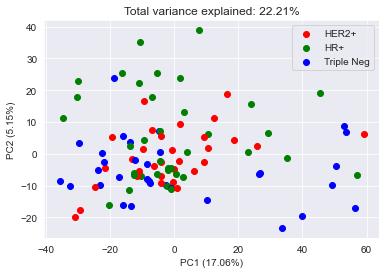

In [79]:
import matplotlib.pyplot as plt

# Assuming you have already applied PCA to your dataset
# and the result is stored in X_pca
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

colors = ['r', 'g', 'b']
class_labels = ['HER2+', 'HR+', 'Triple Neg']
custom_cmap = {1: 'r', 2: 'g', 3: 'b'}
fig, ax = plt.subplots()

for i, label in enumerate(y['Subgroup']):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], color=custom_cmap[y['Subgroup'].iloc[i]])

# Create a custom legend
from collections import OrderedDict
custom_legend = [plt.scatter([], [], color=custom_cmap[class_num], label=class_label) for class_label, class_num in class_mapping.items()]
ax.legend(handles=custom_legend, loc='best')

# Calculate the total variance explained by PC1 and PC2
total_variance_explained = sum(pca.explained_variance_ratio_) * 100

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.title(f'Total variance explained: {total_variance_explained:.2f}%')
plt.show()


# Non-Linear

# Split data to training-validation-testing

In [126]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [127]:
# Check a dataframe for class balance
def check_class_balance(df, target_column):
    print(df[target_column].value_counts())

In [90]:
check_class_balance(y_trainval, 'Subgroup')

2    29
3    26
1    25
Name: Subgroup, dtype: int64


In [91]:
check_class_balance(y_train, 'Subgroup')

2    22
3    21
1    21
Name: Subgroup, dtype: int64


In [92]:
check_class_balance(y_test, 'Subgroup')

2    7
1    7
3    6
Name: Subgroup, dtype: int64


In [93]:
check_class_balance(y_val, 'Subgroup')

2    7
3    5
1    4
Name: Subgroup, dtype: int64


## RFE with SVM

In [128]:
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Create a pipeline with RFE and SVM
pipe = Pipeline([('feature_selection', RFE(SVC(kernel='linear'))), ('classifier', SVC())])

# Define the parameter grid
param_grid = {
    'feature_selection__n_features_to_select': np.arange(10, 100, 5),
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__kernel': ['linear'],
    'classifier__degree': [2, 3, 4],
    'classifier__gamma': ['scale', 'auto']
}

# Create the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_iter=20, cv=5, verbose=2, n_jobs=-1)

# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train, y_train.values.ravel())

# Get the best pipeline
best_pipeline = random_search.best_estimator_

# Transform the data using the best RFE
X_train_selected = best_pipeline.named_steps['feature_selection'].transform(X_train)
X_val_selected = best_pipeline.named_steps['feature_selection'].transform(X_val)
X_test_selected = best_pipeline.named_steps['feature_selection'].transform(X_test)

# Fit the best pipeline on the training data
best_pipeline.fit(X_train_selected, y_train.values.ravel())

# Evaluate the best pipeline on the validation set
y_val_pred = best_pipeline.predict(X_val_selected)
accuracy = accuracy_score(y_val.values.ravel(), y_val_pred)
print(f"Validation accuracy: {accuracy:.3f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Validation accuracy: 0.688


In [129]:
optimal_n = best_pipeline.named_steps['feature_selection'].n_features_
print(f"Optimal number of features: {optimal_n}")

Optimal number of features: 30


# Random Forest feature selection

In [94]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

param_grid = {
    'n_estimators': [5, 50, 100, 150, 200, 250, 300],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 4, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()

# Initialize a 10-fold cross-validated grid search

In [95]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, scoring='accuracy')

# Fit the grid search on the training data

In [96]:
grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 10, 15, 20, 30],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 4, 5, 7, 10],
                         'n_estimators': [5, 50, 100, 150, 200, 250, 300]},
             scoring='accuracy')

# Get the best model

In [97]:
best_rf = grid_search.best_estimator_

# Get the feature importances from the best Random Forest model

In [98]:
feature_importances = best_rf.feature_importances_

# Select the n optimal features

In [99]:
cv_scores = []
n_val = range(1, 300, 5)

In [100]:
for n in n_val:
    top_n_indices = np.argsort(feature_importances)[-n:]
    X_train_selected = X_train[:, top_n_indices]
    cv_score = np.mean(cross_val_score(best_rf, X_train_selected, y_train.values.ravel(), cv=10, scoring='accuracy'))
    cv_scores.append(cv_score)

optimal_n = n_val[np.argmax(cv_scores)]

# Select the top optimal_n features

In [101]:
X_train_selected = X_train[:, np.argsort(feature_importances)[-optimal_n:]]
X_val_selected = X_val[:, np.argsort(feature_importances)[-optimal_n:]]
X_test_selected = X_test[:, np.argsort(feature_importances)[-optimal_n:]]

# Retrain the best model on the selected features

In [102]:
best_rf.fit(X_train_selected, y_train.values.ravel())

RandomForestClassifier(min_samples_split=5, n_estimators=150)

# Evaluate the retrained model on the validation set

In [103]:
y_val_pred = best_rf.predict(X_val_selected)
accuracy = accuracy_score(y_val.values.ravel(), y_val_pred)

print(f"Optimal n: {optimal_n}")
print(f"Validation accuracy: {accuracy}")

Optimal n: 16
Validation accuracy: 0.6875


In [130]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
# One-hot encode the target variable
y_trainval = to_categorical(y_trainval - 1, num_classes=3)
y_test = to_categorical(y_test - 1, num_classes=3)
y_val = to_categorical(y_val - 1, num_classes=3)
y_train = to_categorical(y_train - 1, num_classes=3)

In [132]:
# Build the neural network model with L2 regularization
def create_model(neurons, l2_value):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(optimal_n,), activation='relu', kernel_regularizer=l2(l2_value)))
    model.add(Dense(3, activation='softmax', kernel_regularizer=l2(0.001)))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [133]:
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=16, verbose=0)

C:\Users\nikos\AppData\Local\Temp\ipykernel_5700\3330881601.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=16, verbose=0)


In [134]:
param_grid = {
    'neurons': [16, 32, 64, 128],
    'l2_value': [0.0001, 0.001, 0.01, 0.1]
}

In [135]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2)

In [136]:
grid_result = grid.fit(X_train_selected, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ........................l2_value=0.0001, neurons=16; total time=   0.7s
[CV] END ........................l2_value=0.0001, neurons=16; total time=   0.7s
[CV] END ........................l2_value=0.0001, neurons=16; total time=   0.7s
[CV] END ........................l2_value=0.0001, neurons=16; total time=   0.6s
[CV] END ........................l2_value=0.0001, neurons=16; total time=   0.6s
[CV] END ........................l2_value=0.0001, neurons=32; total time=   0.6s
[CV] END ........................l2_value=0.0001, neurons=32; total time=   0.6s
[CV] END ........................l2_value=0.0001, neurons=32; total time=   0.6s
[CV] END ........................l2_value=0.0001, neurons=32; total time=   0.6s
[CV] END ........................l2_value=0.0001, neurons=32; total time=   0.6s
[CV] END ........................l2_value=0.0001, neurons=64; total time=   0.7s
[CV] END ........................l2_value=0.0001

In [137]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 1.000000 using {'l2_value': 0.0001, 'neurons': 128}


In [138]:
best_n_neurons = grid_result.best_params_['neurons']
best_l2_value = grid_result.best_params_['l2_value']

In [139]:
best_model = create_model(neurons=best_n_neurons, l2_value=best_l2_value)

In [140]:
# Train the model
history = best_model.fit(X_train_selected, y_train, epochs=100, batch_size=16, verbose=1, validation_data=(X_val_selected, y_val))

Epoch 1/100
4/4 [==============================] - 0s 32ms/step - loss: 1.0256 - accuracy: 0.3906 - val_loss: 1.0538 - val_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 0s 8ms/step - loss: 0.8559 - accuracy: 0.6250 - val_loss: 0.9684 - val_accuracy: 0.5625
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7207 - accuracy: 0.7969 - val_loss: 0.9027 - val_accuracy: 0.6250
Epoch 4/100
4/4 [==============================] - 0s 10ms/step - loss: 0.6112 - accuracy: 0.9062 - val_loss: 0.8489 - val_accuracy: 0.6250
Epoch 5/100
4/4 [==============================] - 0s 5ms/step - loss: 0.5194 - accuracy: 0.9688 - val_loss: 0.8069 - val_accuracy: 0.6875
Epoch 6/100
4/4 [==============================] - 0s 11ms/step - loss: 0.4410 - accuracy: 0.9844 - val_loss: 0.7755 - val_accuracy: 0.6875
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.3761 - accuracy: 0.9844 - val_loss: 0.7507 - val_accuracy: 0.6875
Epoch 8/100
4/4 [=======

In [141]:
# Evaluate the model on the test set
y_pred = np.argmax(best_model.predict(X_test_selected), axis=-1)
y_test = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.3f}")

1/1 [==============================] - 0s 28ms/step
Test accuracy: 0.750


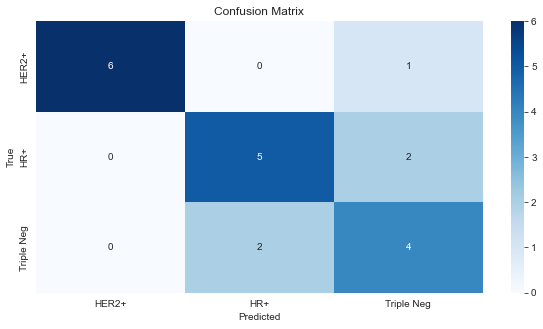

In [142]:
# Calculate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

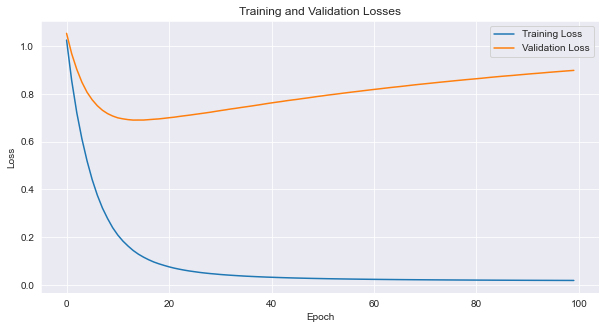

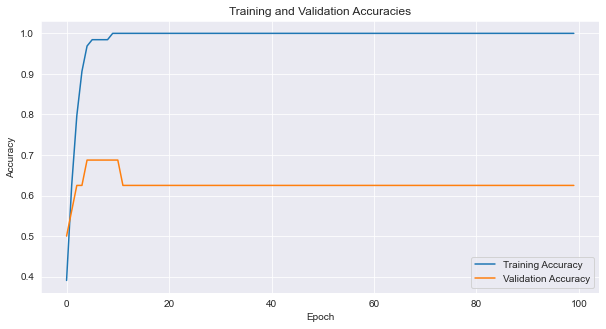

In [143]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

In [144]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.71      0.71      0.71         7
           2       0.57      0.67      0.62         6

    accuracy                           0.75        20
   macro avg       0.76      0.75      0.75        20
weighted avg       0.77      0.75      0.76        20

